In [1]:
import os
import pandas as pd

In [2]:
raw_df = pd.read_csv("data/KBCP/kuopio_data.csv")
raw_df

,SampleID,CaseControl,200047,200050,200261,200262,500301,c1_pos11117461,c1_pos11233043,c1_pos11233263,...,rs9998812,rs9999009,rs999906,rs9999101,rs9999619,rs9999651,rs9999828,rs9999896,rs999995,SNP127
0,KBCP-270,1,0,2,0,2,2,2,2,0,...,1,1,2,1,2,1,2,0,2,2
1,KBCP-185,1,0,2,2,0,2,2,2,1,...,1,1,1,2,1,2,1,0,1,2
2,KBCP-732,1,0,2,2,0,2,2,2,2,...,2,0,1,1,1,1,1,0,2,2
3,KBCP-15,1,0,2,1,2,2,2,2,1,...,2,1,1,2,1,1,2,1,2,2
4,KBCP-108,1,0,2,0,1,2,2,2,1,...,2,0,2,2,1,0,1,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,KBCP-665,0,0,2,0,1,2,2,2,1,...,1,1,1,2,1,1,0,0,1,2
692,KBCP-536,0,0,2,1,1,2,2,2,1,...,2,0,1,2,2,2,2,0,1,2
693,KBCP-563,0,0,2,1,1,2,2,2,1,...,2,0,2,1,1,1,2,0,2,2
694,KBCP-623,0,0,2,1,1,2,2,2,1,...,2,0,0,1,2,0,2,0,1,2


In [3]:
df = raw_df.T.drop_duplicates().T # drop any duplicate columns

In [4]:
from sklearn.preprocessing import StandardScaler
from utils import class_balancing
from sklearn.model_selection import train_test_split
import numpy as np

X = df.drop(columns=['SampleID', 'CaseControl']).values
# Assuming X is your NumPy array
X = X.astype(np.float32) # had issues with the data types
scaler = StandardScaler()
X = scaler.fit_transform(X)  # Scaling the X values
y = df['CaseControl'].values
# Assuming X is your NumPy array
y = y.astype(np.float32)


print(f'\033[92m[INFO]\033[0m Handling imbalance data...')
# Class balancing
X, y = class_balancing(X, y, type='over_sampling', method='SMOTE', random_state=42)

print(f'\033[92m[INFO]\033[0m Splitting the data into development and independent test set...')
# Train test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

[INFO] Handling imbalance data...
[INFO] Splitting the data into development and independent test set...


In [5]:
from graph_representation import create_graph

print(f'\033[92m[INFO]\033[0m Creating the development and test graps...')
# Creating training and test graphs
train_graph = create_graph(X_train, y_train, 'hamming', 15, 0.3, 0.0)
test_graph = create_graph(X_test, y_test, 'hamming', 15, 0.3, 0.0)

[INFO] Creating the development and test graps...


In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch_geometric.nn import GCNConv
from torch_geometric.utils import add_self_loops, to_dense_adj, degree
from sklearn.model_selection import train_test_split
from torch_scatter import scatter_add
from sklearn.metrics import precision_score, recall_score, average_precision_score, accuracy_score, roc_auc_score

ACTIVATIONS = {
    'relu': F.relu,
    'leaky_relu': F.leaky_relu,
    'sigmoid': torch.sigmoid,
    'tanh': torch.tanh
}

class VGAE_GCN(nn.Module):
    def __init__(self, nfeat, hidden_layers, latent_dim, dropout, normalization=True, activation='relu'):
        super(VGAE_GCN, self).__init__()

        if activation not in ACTIVATIONS:
            raise ValueError(f"Activation {activation} not supported. Choose from {list(ACTIVATIONS.keys())}.")

        self.layers = torch.nn.ModuleList()
        layer_sizes = [nfeat] + hidden_layers

        for in_dim, out_dim in zip(layer_sizes[:-1], layer_sizes[1:]):
            self.layers.append(GCNConv(in_dim, out_dim))

        self.mean = GCNConv(hidden_layers[-1], latent_dim)
        self.logstd = GCNConv(hidden_layers[-1], latent_dim)
       
        self.dropout = dropout
        self.normalization = normalization
        self.activation = ACTIVATIONS[activation]

    def encode(self, x, edge_index):
        if self.normalization:
            edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
            row, col = edge_index
            deg = degree(row, dtype=x.dtype)
            deg_inv_sqrt = deg.pow(-0.5)
            norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        else:
            norm = None

        for i, layer in enumerate(self.layers):
            x = layer(x, edge_index, norm)
            if i != len(self.layers) - 1:
                x = self.activation(x)
                x = F.dropout(x, p=self.dropout, training=self.training)

        z_mean = self.mean(x, edge_index, norm)
        z_logstd = self.logstd(x, edge_index, norm)

        # Clamp the logstd to prevent extreme values that can cause instability
        z_logstd = torch.clamp(z_logstd, min=-4, max=4)

        # Debugging step: Check for NaNs before reparameterization
        if torch.isnan(z_mean).any() or torch.isnan(z_logstd).any():
            raise ValueError(f"NaN detected in z_mean or z_logstd at encoding")

        gaussian_noise = torch.randn_like(z_logstd)
        z = z_mean + gaussian_noise * torch.exp(z_logstd)

        # Debugging step: Check for NaNs after reparameterization
        if torch.isnan(z).any():
            raise ValueError(f"NaN detected in z after reparameterization")

        return z

    def forward(self, data):
        z = self.encode(data.x, data.edge_index)
        return z

def dot_product_decode(Z):
    A_pred = torch.sigmoid(torch.matmul(Z, Z.t()))
    return torch.clamp(A_pred, 0, 1)  # Ensure values are strictly within [0, 1]

def contrastive_loss(z1, z2, tau=0.5):
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)

    pos_sim = torch.exp(torch.sum(z1 * z2, dim=1) / tau)  # Positive pairs: same node in both graphs
    neg_sim = torch.exp(torch.mm(z1, z2.t()) / tau)  # Negative pairs: all other node combinations

    neg_sim_sum = neg_sim.sum(dim=1) - pos_sim  # Exclude the positive pair from the denominator
    loss = -torch.log(pos_sim / neg_sim_sum).mean()

    return loss

def training_vgae(train_graph_1, train_graph_2, model, optimizer_name, learning_rate, weight_decay, num_epochs=100, model_save_path='vgae_model.pkl'):
    optimizer = get_optimizer(optimizer_name, model, learning_rate, weight_decay)
    best_loss = float('inf')
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        z1 = model(train_graph_1)
        z2 = model(train_graph_2)
        
        # Dot product decoder (for reconstruction loss)
        A_pred_1 = dot_product_decode(z1)
        A_pred_2 = dot_product_decode(z2)

        # Debugging information
        #print(f"Epoch {epoch}, A_pred_1 min: {A_pred_1.min().item()}, max: {A_pred_1.max().item()}")
        #print(f"Epoch {epoch}, A_pred_2 min: {A_pred_2.min().item()}, max: {A_pred_2.max().item()}")

        adj_dense_1 = to_dense_adj(train_graph_1.edge_index, max_num_nodes=train_graph_1.x.size(0)).squeeze(0)
        adj_dense_2 = to_dense_adj(train_graph_2.edge_index, max_num_nodes=train_graph_2.x.size(0)).squeeze(0)

        adj_dense_1 = (adj_dense_1 > 0).float()
        adj_dense_2 = (adj_dense_2 > 0).float()

        recon_loss_1 = F.binary_cross_entropy(A_pred_1, adj_dense_1)
        recon_loss_2 = F.binary_cross_entropy(A_pred_2, adj_dense_2)

        # Contrastive loss between z1 and z2
        cont_loss = contrastive_loss(z1, z2)

        # Total loss
        loss = recon_loss_1 + recon_loss_2 + cont_loss
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Train Loss: {loss.item()}")

        # Save the best model based on loss
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_model_state = model.state_dict()

    if best_model_state is not None:
        torch.save(best_model_state, model_save_path)

def get_optimizer(optimizer_name, model, learning_rate, weight_decay):
    if optimizer_name.lower() == 'adam':
        return optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name.lower() == 'sgd':
        return optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else:
        raise ValueError(f"Optimizer {optimizer_name} not supported.")

# Example usage:

# Assuming train_graph_1 and train_graph_2 are your two versions of the graph with different adjacency matrices
train_graph_1 = create_graph(X_train, y_train, 'hamming', 15, 0.3, 0.0)
train_graph_2 = create_graph(X_train, y_train, 'hamming', 15, 0.1, 0.0)

model = VGAE_GCN(nfeat=train_graph_1.x.size(1),
                  hidden_layers=[2048, 512],
                  latent_dim=128, dropout=0.2, normalization=True, activation='relu')

training_vgae(train_graph_1=train_graph_1,
              train_graph_2=train_graph_2,
              model=model,
              optimizer_name='Adam',
              learning_rate=0.001, weight_decay=0.02,
              num_epochs=50, model_save_path='vgae_model.pkl')


Epoch 0, Train Loss: 106.47490692138672
Epoch 10, Train Loss: 106.59497833251953


In [34]:
feature_names = df.columns[1:-1].tolist()

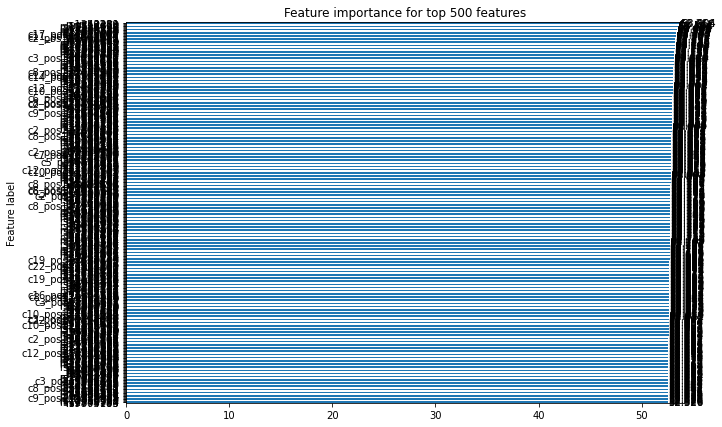

In [38]:
import torch
import torch.nn as nn
import pandas as pd
from tqdm import tqdm
from torch_geometric.data import Data
from torch_geometric.explain import Explainer, GNNExplainer

# Define a wrapper function for your model
class VGAE_GCNWrapper(nn.Module):
    def __init__(self, model):
        super(VGAE_GCNWrapper, self).__init__()
        self.model = model

    def forward(self, x, edge_index, **kwargs):
        data = Data(x=x, edge_index=edge_index)
        return self.model(data)

def graph_node_features_explanation(model, model_path, test_graph, top_features, node_index=100):
    # Load the trained model
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Wrap the original model
    new_model = VGAE_GCNWrapper(model)

    # Initialize the Explainer
    explainer = Explainer(
        model=new_model,
        algorithm=GNNExplainer(epochs=20),
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=dict(
            mode='multiclass_classification',  # Adjust based on your task
            task_level='node',
            return_type='log_probs',
        ),
    )

    # Generate explanation for the specified node index
    explanation = explainer(test_graph.x.cpu(), test_graph.edge_index.cpu(), index=node_index)
    explanation.visualize_feature_importance(feat_labels=top_features, top_k=500)
       

# Assuming you have a trained model and a test graph
# Load the test graph and define the features
test_graph = create_graph(X_test, y_test, 'hamming', 15, 0.3, 0.0)
#top_features = [f'feature_{i}' for i in range(test_graph.num_node_features)]  # Replace with actual feature names

# Initialize the model
model = VGAE_GCN(nfeat=test_graph.x.size(1),
                  hidden_layers=[2048, 512],
                  latent_dim=256, dropout=0.5, normalization=True, activation='relu')

# Path to the trained model
model_path = 'vgae_model.pkl'

# Get the explanation for node index 100
node_index = 100
graph_node_features_explanation(model, model_path, test_graph, feature_names, node_index=node_index)


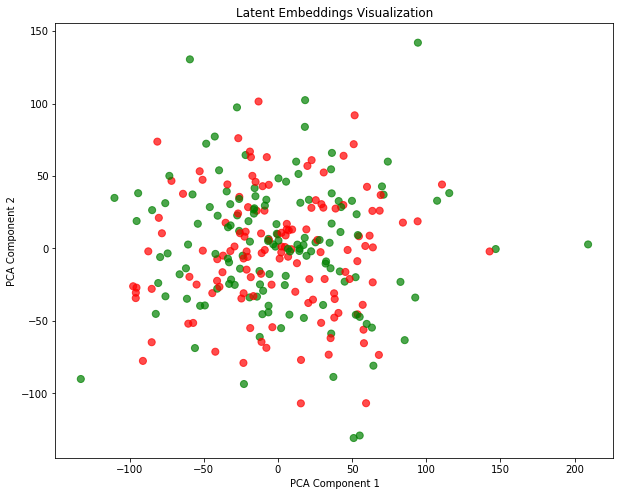

In [37]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.data import Data
from sklearn.decomposition import PCA

# Assuming VGAE_GCN class definition is already available from previous code

# Load the trained model
model = VGAE_GCN(nfeat=test_graph.x.size(1),
                  hidden_layers=[2048, 512],
                  latent_dim=256, dropout=0.5, normalization=True, activation='relu')

model_path = 'vgae_model.pkl'
model.load_state_dict(torch.load(model_path))
model.eval()

# Load the test graph (assuming you have already defined this)
test_graph = create_graph(X_test, y_test, 'hamming', 15, 0.3, 0.0)

# Compute latent embeddings
with torch.no_grad():
    latent_embeddings = model(test_graph).cpu().numpy()

# Perform dimensionality reduction (PCA) for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(latent_embeddings)

# Plot the latent embeddings
plt.figure(figsize=(10, 8))

# Color nodes based on their labels (red for label 1, green for others)
colors = ['red' if label == 1 else 'green' for label in test_graph.y.cpu().numpy()]

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=colors, s=50, alpha=0.7)
plt.title('Latent Embeddings Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [40]:
top_features = feature_names.copy()

In [41]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm import tqdm  # Import tqdm for progress monitoring
from torch_geometric.data import Data

# Define a wrapper function for your model
class VGAE_GCNWrapper(nn.Module):
    def __init__(self, model):
        super(VGAE_GCNWrapper, self).__init__()
        self.model = model

    def forward(self, x, edge_index, **kwargs):
        data = Data(x=x, edge_index=edge_index)
        return self.model(data)

def perturbation_feature_importance(model, model_path, test_graph, top_features, node_index=None, perturbation='mask', noise_level=0.1):
    # Load the trained model
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Wrap the original model
    new_model = VGAE_GCNWrapper(model)

    # Compute the original prediction
    with torch.no_grad():
        original_output = new_model(test_graph.x, test_graph.edge_index)
        original_output = original_output[node_index].cpu().numpy()

    # Initialize a dictionary to store feature importance scores
    feature_importance = {feature: 0.0 for feature in top_features}

    # Loop over each feature to perturb and compute the importance score
    for i, feature_name in enumerate(tqdm(top_features, desc="Computing Feature Importance")):
        x_perturbed = test_graph.x.clone()

        # Apply perturbation
        if perturbation == 'mask':
            x_perturbed[node_index, i] = 0  # Mask the feature
        elif perturbation == 'noise':
            noise = noise_level * torch.randn_like(x_perturbed[node_index, i])
            x_perturbed[node_index, i] += noise  # Add noise to the feature

        # Compute the perturbed prediction
        with torch.no_grad():
            perturbed_output = new_model(x_perturbed, test_graph.edge_index)
            perturbed_output = perturbed_output[node_index].cpu().numpy()

        # Calculate the importance as the difference in prediction
        feature_importance[feature_name] = np.abs(original_output - perturbed_output).sum()

    # Normalize importance scores
    total_importance = sum(feature_importance.values())
    for feature_name in feature_importance:
        feature_importance[feature_name] /= total_importance

    # Convert the importance scores to a DataFrame
    importance_df = pd.DataFrame.from_dict(feature_importance, orient='index', columns=['Importance'])
    importance_df = importance_df.reset_index().rename(columns={'index': 'Feature'})

    return importance_df

# Example usage:

# Assuming you have a trained model and a test graph
# Load the test graph and define the features
test_graph = create_graph(X_test, y_test, 'hamming', 15, 0.3, 0.0)
top_features = [f'feature_{i}' for i in range(test_graph.num_node_features)]  # Replace with actual feature names

# Initialize the model
model = VGAE_GCN(nfeat=test_graph.x.size(1),
                  hidden_layers=[2048, 512],
                  latent_dim=256, dropout=0.5, normalization=True, activation='relu')

# Path to the trained model
model_path = 'vgae_model.pkl'

# Compute feature importance for a specific node index
node_index = 100
importance_df = perturbation_feature_importance(model, model_path, test_graph, top_features, node_index=node_index, perturbation='mask')

# Display the results
print(importance_df)


Computing Feature Importance:   3%|▎         | 3342/115894 [18:53:32<636:15:37, 20.35s/it]   


KeyboardInterrupt: 